# Histone modifications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

random_seed = 123
np.random.seed(random_seed)

[PyCaret](https://pycaret.org/) is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.

It is not available by default, so we first install the library.

In [2]:
! pip install pycaret

     |████████████████████████████████| 256kB 6.5MB/s 
     |████████████████████████████████| 266kB 12.3MB/s 
     |████████████████████████████████| 66.3MB 63kB/s 
     |████████████████████████████████| 1.6MB 38.7MB/s 
     |████████████████████████████████| 6.8MB 43.6MB/s 
     |████████████████████████████████| 276kB 46.7MB/s 
     |████████████████████████████████| 1.8MB 44.4MB/s 
     |████████████████████████████████| 157.5MB 84kB/s 
     |████████████████████████████████| 174kB 40.5MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 13.9MB 256kB/s 
     |████████████████████████████████| 3.1MB 43.8MB/s 
     |████████████████████████████████| 604kB 30.7MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 2.1MB 39.7MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 153kB 40.3MB/s 
 

In [3]:
!pip install -q tf-nightly

     |████████████████████████████████| 399.6MB 36kB/s 
     |████████████████████████████████| 471kB 43.1MB/s 
     |████████████████████████████████| 12.2MB 48.9MB/s 
     |████████████████████████████████| 3.8MB 46.9MB/s 
     |████████████████████████████████| 14.5MB 231kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


# 1. The data

Histone modifications play an important role in affecting gene regulation. Specific histone modifications at specific locations in or near the gene can alter the expression of genes. Predicting gene expression from histone modification signals is a widely studied research topic.

In this competition you will predict gene expression levels (low=0, high=1) based on the presence of histone modifications at specific locations in the gene. You will try to find the model that learns the true underlying model best.

For each gene a region of 10.000bp around the transcription start site of the gene is extracted (5000bp upstream and 5000bp downstream). This region is binned in 100 bins of 100bp. For each bin five core histone modification marks are counted [1].

The dataset is compiled from the "E047" (Primary T CD8+ naive cells from peripheral blood) celltype from Roadmap Epigenomics Mapping Consortium (REMC) database.

[1] Kundaje, A. et al. Integrative analysis of 111 reference human epige-
nomes. Nature, 518, 317–330, 2015.


We start by loading the Pandas library and reading the datasets into Pandas DataFrames:

In [4]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data/data_test.csv")

Import TensorFlow

In [5]:
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Let's look at a random sample of the training set:

In [ ]:
# train.sample(20)

An alternative visualization for this type of counting data is the heatmap.

In [ ]:
import seaborn as sns

plt.figure(figsize=(30,10))
sns.heatmap(train.sample(20))

In [6]:
from PIL import Image as im

The label for each datapoint is in the `Label` column.

In [7]:
train_labels = train.pop("Label")

In [8]:
train_index_col = train.pop("GeneId")

Now `train` contains the feature columns only.

Let's look at the number datapoints in each class:

In [9]:
train_labels.value_counts()

1    5250
0    5186
Name: Label, dtype: int64

Let's look at `test`:

In [ ]:
test.head(5)

This is a blind test so the `Label` column is not available in the test set. The test set does contain the `GeneId` column that is needed to send your predictions to the Kaggle website.


In [9]:
test_index_col = test.pop("GeneId")

We can compute some decriptive statistics about the training set using the DataFrame `.describe()` function:

In [ ]:
train.describe()

We can plot these descriptive statistics to get a general overview of the data.

In [ ]:
for col in ["count","mean","std","min","max"]:
  sns.distplot(pd.DataFrame(train.describe().transpose())[col])
  plt.show()

We can use the Pandas `boxplot()` function to plot the feature values.

In [ ]:
plt.figure(figsize=(22,8))
train.boxplot()
plt.show()

Let's plot these for each hisotone mark.

In [10]:
marks = {}
for m in train.columns:
  marks[m.split("_")[0]] = True
marks = list(marks.keys())
marks

['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']

In [11]:
os.mkdir("methylation_images")
os.mkdir("methylation_images/Label_0")
os.mkdir("methylation_images/Label_1")
maximum_train = train.max().max()

In [156]:
os.mkdir("test_images")
maximum_test = test.max().max()

In [ ]:
train_rowsums = train.sum(axis=1)
train_rowsums = train_rowsums / train_rowsums.max() * maximum_train
train_rowsds = np.std(train, axis=1)
train_rowsds = train_rowsds / train_rowsds.max() * maximum_train

In [157]:
test_rowsums = test.sum(axis=1)
test_rowsums = test_rowsums / test_rowsums.max() * maximum_test
test_rowsds = np.std(test, axis=1)
test_rowsds = test_rowsds / test_rowsds.max() * maximum_test

In [134]:
for index, row in train.iterrows():
  array = np.full_like(np.arange(100, dtype=int), np.round(train_rowsums[index], 0))
#  array = np.column_stack((array, np.full_like(np.arange(100, dtype=int), np.round(train_rowsums[index], 0))))
#  array = np.column_stack((array, np.full_like(np.arange(100, dtype=int), np.round(train_rowsds[index], 0))))
#  array = np.column_stack((array, np.full_like(np.arange(100, dtype=int), np.round(train_rowsds[index], 0))))
  for mark in marks:
    cols = []
    for m in train.columns:
      if mark in m:
        cols.append(train[m][index])
    cols = np.array(cols)
    array = np.column_stack((array, cols))
    array = np.column_stack((array, cols))
    array = np.column_stack((array, cols))
    array = np.column_stack((array, cols))
  array = np.transpose(array)[1:21]
  array = 255 - (array / maximum_train * 255)
  array = np.round(array,0).astype(int)
  img = im.fromarray(np.uint8(array) , 'L')
  if train_labels[index] == 0:
    img.save("methylation_images/Label_0/" + train_index_col[index].astype(str) + ".png")
  if train_labels[index] == 1:
    img.save("methylation_images/Label_1/" + train_index_col[index].astype(str) + ".png")

In [158]:
for index, row in test.iterrows():
  array = np.full_like(np.arange(100, dtype=int), np.round(test_rowsums[index], 0))
  for mark in marks:
    cols = []
    for m in test.columns:
      if mark in m:
        cols.append(test[m][index])
    cols = np.array(cols)
    array = np.column_stack((array, cols))
    array = np.column_stack((array, cols))
    array = np.column_stack((array, cols))
    array = np.column_stack((array, cols))
  array = np.transpose(array)[1:21]
  array = 255 - (array / maximum_test * 255)
  array = np.round(array,0).astype(int)
  img = im.fromarray(np.uint8(array) , 'L')
  img.save("test_images/" + test_index_col[index].astype(str) + ".png")

In [136]:
batch_size = 32
img_height = 20
img_width = 100
import pathlib
data_dir = pathlib.Path("methylation_images/")

In [137]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10436 files belonging to 2 classes.
Using 8349 files for training.
Found 10436 files belonging to 2 classes.
Using 2087 files for validation.


In [138]:
class_names = train_ds.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [237]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(20, 100, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [238]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [239]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
261/261 [==============================] - 14s 51ms/step - loss: 0.6089 - accuracy: 0.6332 - val_loss: 0.4204 - val_accuracy: 0.8313
Epoch 2/30
261/261 [==============================] - 13s 51ms/step - loss: 0.4223 - accuracy: 0.8330 - val_loss: 0.4031 - val_accuracy: 0.8414
Epoch 3/30
261/261 [==============================] - 13s 51ms/step - loss: 0.4191 - accuracy: 0.8357 - val_loss: 0.3950 - val_accuracy: 0.8433
Epoch 4/30
261/261 [==============================] - 13s 51ms/step - loss: 0.4140 - accuracy: 0.8349 - val_loss: 0.4080 - val_accuracy: 0.8275
Epoch 5/30
261/261 [==============================] - 13s 50ms/step - loss: 0.4102 - accuracy: 0.8369 - val_loss: 0.3918 - val_accuracy: 0.8400
Epoch 6/30
261/261 [==============================] - 13s 51ms/step - loss: 0.4056 - accuracy: 0.8404 - val_loss: 0.3848 - val_accuracy: 0.8400
Epoch 7/30
261/261 [==============================] - 13s 51ms/step - loss: 0.4203 - accuracy: 0.8291 - val_loss: 0.3906 - val_accuracy:

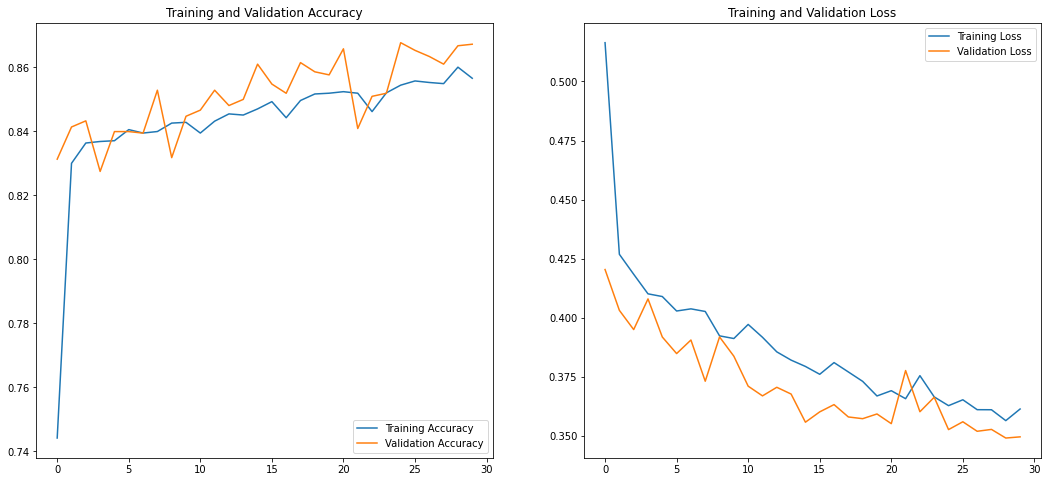

In [240]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [241]:
final_scores = []
place = 0
for id in test_index_col:
  place = place + 1
  print(place)
  image_path = "test_images/" + str(id) + ".png"
  img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  final_scores.append(score[1].numpy())

Streaming output truncated to the last 5000 lines.
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299

In [242]:
zeroed_scores = np.round(final_scores,0).astype(int)

In [243]:
to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = final_scores
to_write.to_csv("submission11.csv",index=False)

# 2. Our first model

Let's fit a Logistic Regression model. We will first use the very popular (with good reason) [Scikit-learn](https://scikit-learn.org/stable/) library for that.

First, we hold out 20% if the training data for independant validation.

Next, we fit the modelparameters on the training set and evaluate the fitted model on the validation set.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls = LogisticRegression()

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

# 3. How well does it perform in pratice?

In [ ]:
#code for submission
predictions_test = cls.predict(test)

to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = predictions_test
to_write.to_csv("submission1.csv",index=False)

For the Kaggle competition your predictions are not evaluated by accuracy, but by log-loss:

$$ - \frac{1}{N} \sum_{i=1}^N [y_{i} \log \, p_{i} + (1 - y_{i}) \log \, (1 - p_{i})],$$

where $N$ is the number of datapoints, $y_i$ is the label of datapoint $i$, and $p_i$ is the prediction of the model expressed as a probability.

Let's compute the log-loss:

In [ ]:
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train),log_loss(val_y,predictions_val)))

# 4. Data pre-processing




Let's scale all the features to [0,1]:

In [ ]:
from sklearn import preprocessing

scaler_minmax = preprocessing.MinMaxScaler()
scaler_minmax.fit(train)
train_norm = pd.DataFrame(scaler_minmax.transform(train),columns=train.columns)
train_norm.head()

In [ ]:
for mark in marks:
  cols = []
  for m in train_norm.columns:
    if mark in m:
      cols.append(m)
  plt.figure(figsize=(22,8))    
  train_norm[cols].boxplot()
  plt.show()

Now, did we improve the predictions?

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

# 5. Hyperparameter tuning

From now on we will use the PyCaret library for fitting models. It provides many useful functions that make Machine Learning fun.

To use PyCaret we first need to setup an environment that prepares the data for fitting and validation.

In [ ]:
from pycaret.classification import *

train_norm["Label"] = train_labels
setup(data=train_norm,target="Label",numeric_features=list(train.columns)[:-1], train_size=0.8, silent=True)

By default, PyCaret does not compute the log-loss metric. So, we add it.

In [ ]:
from sklearn.metrics import log_loss

add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Next, we fit a model using `create_model` that is similar to `fit()` in Scikit-learn, except that it fits and evaluates (CV) on the 80% fitting part of the training set only. The output of this function is a score grid with CV scores by fold.

In [ ]:
lr = create_model("lr")

We just fitted a Logistic Regression model with a default value of 1.0 for the regularization parameter, as you can see below.

In [ ]:
lr

In [ ]:
result = predict_model(lr)

It is now easy to optimize (tune) this hyperparameter.

In [ ]:
tune_grid = {
    "C": np.linspace(0.0001,10,1000)
    }

tuned_lr = tune_model(lr,tuner_verbose=2, n_iter=10, fold=5, custom_grid=tune_grid)

`tune_model()` applies an random search on the `tune_grid` where each point in the seach space is evaluated using cross-validation:

<br/>
<br/>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png"/>
<br/>
<br/>


This is the 'optimal' value for the regularization hyperparameter:

In [ ]:
tuned_lr

We can now again test this model on the validation set.

In [ ]:
result = predict_model(tuned_lr)

PyCaret offers some very useful tools for model validation.

In [ ]:
evaluate_model(tuned_lr)

Finally, we can fit the optimal model on the full training set. 

In [ ]:
final_lr = finalize_model(tuned_lr)

To obtain insight into how the model uses each of the features we can look at the values of the modelparameters.

In [ ]:
tmp = []
for feature, modelparameter in zip(train.columns,final_lr.coef_[0]):
  tmp.append([feature,np.abs(modelparameter)])

tmp = pd.DataFrame(tmp,columns=["feature","modelparameter"])

tmp.sort_values("modelparameter",ascending=False)

And the we can make predictions for the blind test set. PyCaret adds two columns to the test set: Label (the predicted class) and Score (the probability of class 1).

In [ ]:
result = predict_model(final_lr,data=test)
print(result)

In [ ]:
to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = result["Score"]
to_write.to_csv("submission2.csv",index=False)